<a href="https://colab.research.google.com/github/NoeGille/UNet-on-fashion-mnist/blob/main/UNet_on_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code for UNet model found on

https://www.augustehoangduc.fr/comment-implementer-u-net-pour-faire-de-la-segmentation-dimage/

In [25]:
import keras.datasets.fashion_mnist as fashion_mnist

# Load data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

(60000, 28, 28)
[9 0 0 ... 3 0 5]


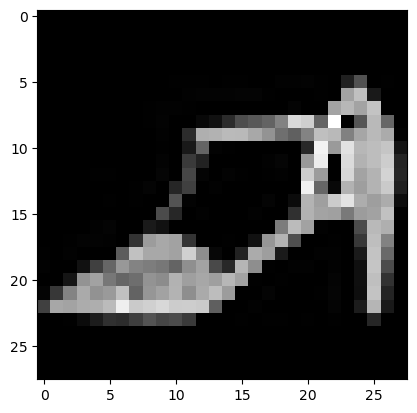

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from random import choice
import cv2

plt.imshow(choice(X_train), cmap='gray')
print(X_train.shape)
print(y_train)

## Adjusting data for the model

In [27]:
IMG_SHAPE = (28, 28, 1)

def create_y(X):
  y = np.array([cv2.threshold(img, 8, 255, type=cv2.THRESH_BINARY)[1] for img in X])
  y = np.where(y == 0, 0, 1)
  return np.array(y)


y_train = create_y(X_train)
y_test = create_y(X_test)


In [28]:
X_train = ((np.array(np.expand_dims(X_train, axis=-1), dtype=np.float64) - X_train.mean()) / np.sqrt(X_train.var()))
y_train = np.array(np.expand_dims(y_train, axis=-1), dtype=np.float64)

X_test = ((np.array(np.expand_dims(X_test, axis=-1), dtype=np.float64) - X_test.mean()) / np.sqrt(X_test.var()))
y_test = np.array(np.expand_dims(y_test, axis=-1), dtype=np.float64)

In [29]:
print(X_train.mean())
print(X_train.var())
n = np.random.randint(0, 60000)
plt.imshow(X_train[n],cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(y_train[n,:,:],cmap='gray')
plt.colorbar()
plt.show()

-1.74808013869143e-17


The data seems to be good.

## Creation of the model

In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Concatenate, Input, BatchNormalization, Dropout


def create_model():
    def DoubleConvolution(filters, inputs):
        """
        Double convolution layer used at every down sample and residual connection
        filters : outputs filter dimension
        inputs : input tensor
        """
        y = Conv2D(filters = filters, 
                   kernel_size = (3,3), 
                   padding = 'same',
                   kernel_initializer='he_normal', 
                   activation='elu')(inputs)
        y = BatchNormalization()(y)
        y = Dropout(0.1) (y)
        y = Conv2D(filters = filters, 
                   kernel_size = (3,3), 
                   padding = 'same', 
                   kernel_initializer='he_normal', 
                   activation='relu')(y)
        y = BatchNormalization()(y)
        y = Dropout(0.1) (y)
        
        return y
    def DownSample(filters, inputs):
        """
        Reduce size of image
        filters : outputs filter dimension
        inputs : input tensor
        """
        y = MaxPooling2D(pool_size=(2,2), padding='valid')(inputs)
        y = DoubleConvolution(filters, y)
        return y
    
    def UpSample(filters, inputs):
        """
        Increase size of image
        filters : outputs filter dimension
        inputs : input tensor
        """
        y = UpSampling2D(size=(2,2))(inputs)
        y = Conv2D(filters=filters, kernel_size=(3,3), activation='elu', padding='same')(y)
        y = BatchNormalization()(y)
        return y

    def ResidualConnection(filters, input_1, input_2):
        """
        Concatenate inputs of two blocks
        filters : outputs filter dimension
        input_1 : first input
        input_2 : second input
        """
        y = Concatenate(axis=-1)([input_1, input_2])
        y = DoubleConvolution(filters, y)
        return y
      
    input = Input(shape=(IMG_SHAPE))

    #shape =(28, 28, 1)
    Conv0 = DoubleConvolution(64, input)
    #shape =(28, 28, 64)
    Conv1 = DownSample(128, Conv0)
    #shape =(14, 14, 128)
    Conv2 = DownSample(256, Conv1)
    #shape =(7, 7, 256)

    UpConv1 = UpSample(128, Conv2)
    Res1 = ResidualConnection(128, Conv1, UpConv1)
    #shape =(14, 14, 128)

    UpConv0 = UpSample(128, UpConv1)
    Res0 = ResidualConnection(64, Conv0, UpConv0)
    #shape =(28, 28, 64)

    output = Conv2D(1, kernel_size=(1,1), activation = 'sigmoid')(Res0) # shape = (28, 28, 1)

    return Model(input, output)

In [ ]:
IMG_SHAPE = (28,28,1)
model = create_model()

In [ ]:
from keras.metrics import MeanIoU
from keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=['accuracy'])

## Training

In [ ]:
from keras.engine.training import callbacks_module
from keras.callbacks import ModelCheckpoint
# Allows us to keep track of training data
callbacks = []
callbacks.append(ModelCheckpoint('drive/My Drive/model_checkpoint.h5',monitor='val_loss',verbose=1,save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch'))

# We choose to use less data to get good results fot plotting.
# To get a better model, we could increase the batch size and the number of data example
# by changing epochs and steps_per_epoch

BATCH_SIZE = 4
history = model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=10, steps_per_epoch=len(X_train) // (BATCH_SIZE * 50), verbose=1, callbacks=callbacks)


Epoch 1/10
299/300 [============================>.] - ETA: 0s - loss: 0.0946 - accuracy: 0.9633
Epoch 1: saving model to drive/My Drive\model_checkpoint.h5
300/300 [==============================] - 24s 14ms/step - loss: 0.0944 - accuracy: 0.9634
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 0.0427 - accuracy: 0.9852
Epoch 2: saving model to drive/My Drive\model_checkpoint.h5
300/300 [==============================] - 4s 12ms/step - loss: 0.0427 - accuracy: 0.9852
Epoch 3/10
296/300 [============================>.] - ETA: 0s - loss: 0.0313 - accuracy: 0.9890
Epoch 3: saving model to drive/My Drive\model_checkpoint.h5
300/300 [==============================] - 4s 12ms/step - loss: 0.0314 - accuracy: 0.9889
Epoch 4/10
300/300 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9913
Epoch 4: saving model to drive/My Drive\model_checkpoint.h5
300/300 [==============================] - 4s 12ms/step - loss: 0.0245 - accuracy: 0.9913
Epoch 5/10
300/

In [ ]:
model.evaluate(x=X_test, y=y_test)

313/313 [==============================] - 4s 9ms/step - loss: 0.0097 - accuracy: 0.9964


[0.009688453748822212, 0.9963947534561157]

The model gives good results. Let's plot an example to see if everything is okay.

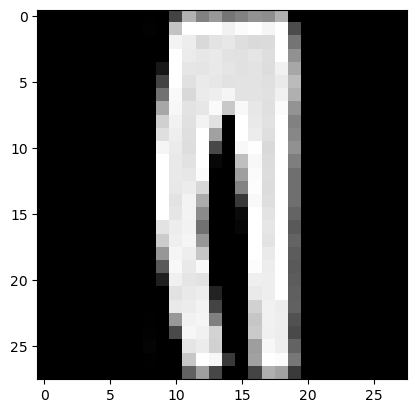

313/313 [==============================] - 2s 7ms/step


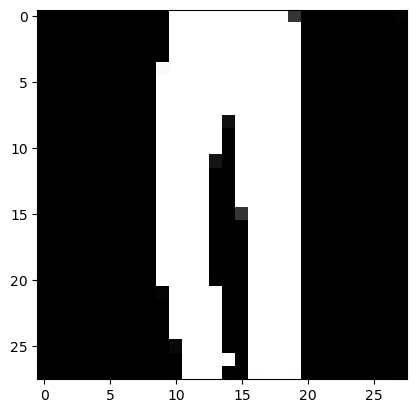

In [ ]:
plt.imshow(X_test[2], cmap='gray')
plt.show()
prediction = model.predict(X_test)

plt.imshow(prediction[2], cmap='gray')
plt.show()

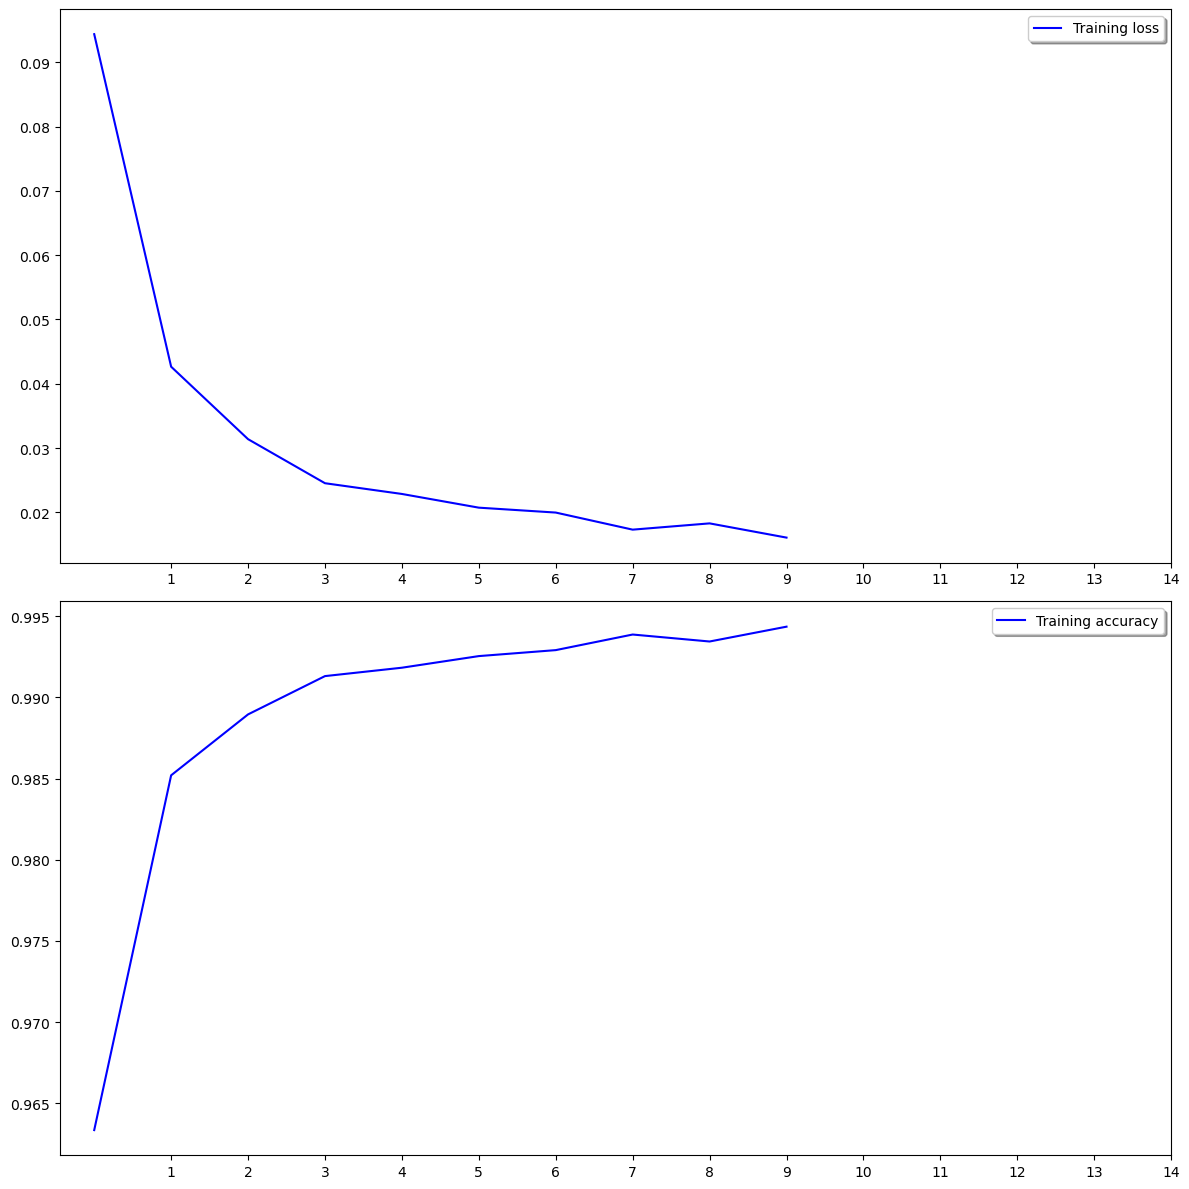

In [ ]:
epochs = 15

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.legend(loc='best', shadow=True)
#ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Multi-classes segmentation

The problem is now to segment pixels depending on what type of clothes their are from.


In [ ]:
from tqdm import tqdm
from keras.utils import to_categorical
# X_train and X_test stay the same. We need new y prediction
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


def create_targets(X, y_label):
    '''y should be a matrix where pixels have the value of their classes and not a matrix with 10 channels.
    The following code is wrong'''
    y = np.array([cv2.threshold(img, 8, 255, type=cv2.THRESH_BINARY)[1] for img in X])
    y = np.where(y == 0, 0, 1)
    y_res = np.zeros((*y.shape, 10))
    for s in tqdm(range(y_res.shape[0])):
      for i in range(y_res.shape[1]):
        for j in range(y_res.shape[2]):
          if y[s,i,j] == 1:
            y_res[s, i, j, y_label[s]] = 1
    return y_res

def create_targets(X, y_label):
    y = np.array([cv2.threshold(img, 8, 255, type=cv2.THRESH_BINARY)[1] for img in X])
    y = np.where(y == 0, 0, 1)
    for s in tqdm(range(y.shape[0])):
      y[s] *= y_label[s] + 1
    return to_categorical(y)

y_train = create_targets(X_train, y_train)


100%|██████████| 60000/60000 [00:00<00:00, 299334.08it/s]


In [ ]:
# Normalizing input data
X_train = ((np.array(np.expand_dims(X_train, axis=-1), dtype=np.float64) - X_train.mean()) / np.sqrt(X_train.var()))

# Computing valid output test data
y_test = create_targets(X_test, y_test)
X_test = ((np.array(np.expand_dims(X_test, axis=-1), dtype=np.float64) - X_test.mean()) / np.sqrt(X_test.var()))



100%|██████████| 10000/10000 [00:00<00:00, 281159.14it/s]


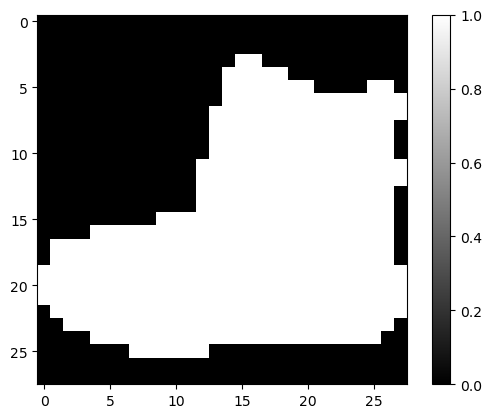

In [ ]:
# Sample 0 with class 10
plt.imshow(y_train[0, :, :, 10],cmap='gray')
plt.colorbar()
plt.show()
# Showing class 9 of the same sample

## Model

We're gonna use the same model as before but with 10 classes for the ouput

In [ ]:
IMG_SHAPE = (28,28,1)

def create_model():
    def DoubleConvolution(filters, inputs):
        """
        Double convolution layer used at every down sample and residual connection
        filters : outputs filter dimension
        inputs : input tensor
        """
        y = Conv2D(filters = filters, 
                   kernel_size = (3,3), 
                   padding = 'same',
                   kernel_initializer='he_normal', 
                   activation='relu')(inputs)
        y = BatchNormalization()(y)
        y = Dropout(0.1) (y)
        y = Conv2D(filters = filters, 
                   kernel_size = (3,3), 
                   padding = 'same', 
                   kernel_initializer='he_normal', 
                   activation='relu')(y)
        y = BatchNormalization()(y)
        y = Dropout(0.1) (y)
        
        return y
    def DownSample(filters, inputs):
        """
        Reduce size of image
        filters : outputs filter dimension
        inputs : input tensor
        """
        y = MaxPooling2D(pool_size=(2,2), padding='valid')(inputs)
        y = DoubleConvolution(filters, y)
        return y
    
    def UpSample(filters, inputs):
        """
        Increase size of image
        filters : outputs filter dimension
        inputs : input tensor
        """
        y = UpSampling2D(size=(2,2))(inputs)
        y = Conv2D(filters=filters, kernel_size=(3,3), activation='relu', padding='same')(y)
        y = BatchNormalization()(y)
        return y

    def ResidualConnection(filters, input_1, input_2):
        """
        Concatenate inputs of two blocks
        filters : outputs filter dimension
        input_1 : first input
        input_2 : second input
        """
        y = Concatenate(axis=-1)([input_1, input_2])
        y = DoubleConvolution(filters, y)
        return y
      
    input = Input(shape=(IMG_SHAPE))

    #shape =(28, 28, 1)
    Conv0 = DoubleConvolution(64, input)
    #shape =(28, 28, 64)
    Conv1 = DownSample(128, Conv0)
    #shape =(14, 14, 128)
    Conv2 = DownSample(256, Conv1)
    #shape =(7, 7, 256)

    UpConv1 = UpSample(128, Conv2)
    Res1 = ResidualConnection(128, Conv1, UpConv1)
    #shape =(14, 14, 128)

    UpConv0 = UpSample(128, UpConv1)
    Res0 = ResidualConnection(64, Conv0, UpConv0)
    #shape =(28, 28, 64)
    
    # This is the only line that changes
    output = Conv2D(11, kernel_size=(1,1), activation = 'sigmoid')(Res0) # shape = (28, 28, 11)

    return Model(input, output)

In [ ]:
model = create_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:

BATCH_SIZE = 16
history = model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=1, steps_per_epoch=len(X_train) // BATCH_SIZE, verbose=1)



ValueError: in user code:

    File "d:\Anaconda\envs\gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "d:\Anaconda\envs\gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Anaconda\envs\gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "d:\Anaconda\envs\gpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "d:\Anaconda\envs\gpu\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Anaconda\envs\gpu\lib\site-packages\keras\engine\input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model_1" "                 f"(type Functional).
    
    Input 0 of layer "batch_normalization_12" is incompatible with the layer: expected ndim=4, found ndim=6. Full shape received: (16, 28, 28, 1, 1, 64)
    
    Call arguments received by layer "model_1" "                 f"(type Functional):
      • inputs=tf.Tensor(shape=(16, 28, 28, 1, 1, 1), dtype=float32)
      • training=True
      • mask=None


In [ ]:
model.evaluate(x=X_test, y=y_test)

313/313 [==============================] - 4s 9ms/step - loss: 0.3392 - accuracy: 0.8808


[0.3391830623149872, 0.8808398246765137]

In [ ]:
y_pred = model.predict(X_test)

313/313 [==============================] - 2s 6ms/step


In [ ]:
# We will plot the argmax for each pixel
'''
1 	T-shirt/top 
2 	Trouser 
3 	Pullover 
4 	Dress 
5 	Coat 
6 	Sandal 
7 	Shirt 
8 	Sneaker 
9 	Bag 
10 	Ankle
'''
n = 11
fig = plt.figure()
fig.add_subplot(1,2,1)
img = np.argmax(y_pred, axis=3)
plt.imshow(X_test[n], cmap='gray')
fig.add_subplot(1,2,2)
img = np.ma.masked_where(img == 0, img)
plt.imshow(img[n], vmin=1, vmax=10, cmap='tab10')
plt.colorbar()
plt.show()





NameError: name 'plt' is not defined